<a href="https://colab.research.google.com/github/prekshya-dawadi/GDLLabs/blob/main/Day_4_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self supervised Learning Lab

This lab focuses on self-supervised contrastive learning, a method for extracting meaningful features from unlabeled data. Self-supervised learning avoids the need for manual labeling by leveraging patterns and differences within the data itself, enabling models to adapt quickly to downstream tasks. For instance, in autonomous driving, large datasets can be collected by mounting a camera in a car, saving significant time and cost compared to manual annotation.

Recent advancements in self-supervised learning, particularly in contrastive learning, have demonstrated impressive performance with minimal labeled data. Contrastive learning trains models to cluster augmented versions of an image while maximizing their separation from other images. A notable method, SimCLR, uses augmentations like cropping, noise, and blurring, combined with a CNN (e.g., ResNet), to produce robust feature representations. (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_contrastive_learning.png?raw=1" width="500px"></center>

The framework involves creating augmented versions of unlabeled images, processing them through a network, and training the outputs to align closely for augmented pairs while diverging for unrelated images. This helps the model focus on invariant content, such as objects, that are essential for downstream tasks.

The lab will compare downstream task performance between:

- A model trained using feature extractor initialized with SimCLR-pretrained feature extractors (trained in a self-supervised manner).
- A model trained using feature extractor initialized with fully supervised training (e.g., on a labeled dataset like ImageNet).

This comparison evaluates the effectiveness of SimCLR-pretrained features and their ability to serve as a foundation for task-specific fine-tuning, offering an efficient alternative to fully supervised training.

This lab is heavily inspired by and adapted from the labs provided in the "Lecture Series on Deep Learning" at the University of Amsterdam.

In [1]:
## Standard libraries
import os
import random
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

#numpy
import numpy as np

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Setting the seed

fix_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

<ipython-input-1-e57d2610f6ae>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

```ContrastiveTransformations``` class generates multiple augmented versions of an image for SimCLR. In SimCLR, two augmented views of the same image are created to form positive pairs for training.

- Base Transforms: A set of data augmentations (e.g., cropping, color distortion) applied to the image.
- Number of Views (n_views): Specifies how many augmented versions to generate (typically 2 for SimCLR).
- Functionality: When called, the class applies the augmentations multiple times to create a list of augmented views.

This is used in SimCLR to train the model to recognize similarities between augmented views of the same image while distinguishing them from other images.

In [3]:
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [4]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

This code block loads the **STL-10 dataset** and applies contrastive transformations to prepare it for SimCLR training. The unlabeled split is used for self-supervised pretraining, and the labeled training split is prepared similarly for later evaluation. Each image is augmented twice to generate positive pairs for contrastive learning.[link text](https://)

In [5]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

100%|██████████| 2.64G/2.64G [07:03<00:00, 6.23MB/s]


Extracting ../data/stl10_binary.tar.gz to ../data
Files already downloaded and verified


Now, we visualize examples of augmented images from the STL-10 dataset. We generate two augmented versions for each image using the contrastive transformations and display them in a grid. This allows us to see the variety and diversity introduced by the augmentation process, which is crucial for contrastive learning.

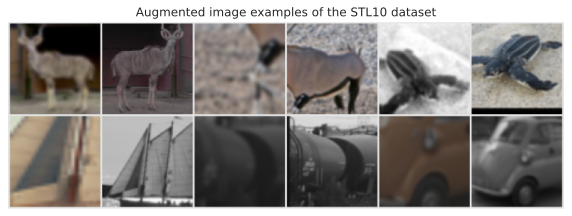

In [6]:
# Visualize some examples
fix_seed(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We define a CNN model, Resnet18SimCLR, based on ResNet-18 to use for SimCLR. The model includes:

Backbone CNN: ResNet-18 is used as the base feature extractor, with its fully connected layer (fc) replaced.

Projection Head: The modified fc layer consists of two linear layers with a ReLU activation in between. It maps the ResNet features into a lower-dimensional space, as required for contrastive learning.
This architecture is designed to extract features from input images and project them into a representation space where SimCLR can effectively learn similarities and differences between augmented image pairs.

In [7]:
class Resnet18SimCLR(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet18SimCLR, self).__init__()

        # Backbone CNN
        self.convnet = torchvision.models.resnet18(num_classes=4 * hidden_dim)
        # cnn_dim = self.cnn_dim = self.cnn.fc.in_features

        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def forward(self, image):
        out = self.conv_net(image)
        return out


In [8]:
simclr_resnet = Resnet18SimCLR(128)

Since we don’t have sufficient computational resources to train the model from scratch using self-supervised learning, we will load a pre-trained checkpoint. This checkpoint contains a model that has already been trained on the STL-10 unlabeled dataset using SimCLR. This allows us to skip the training process and directly use the pre-trained model for downstream tasks or further evaluation

In [9]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
simclr_ckpt = torch.load(pretrained_filename)

<ipython-input-9-ebfb1db53b8e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_ckpt = torch.load(pretrained_filename)


In [10]:
simclr_resnet.load_state_dict(simclr_ckpt['state_dict'])

<All keys matched successfully>

### CNN Class Description

This code defines a class `CNN`, which is a neural network based on ResNet-18, designed for classification tasks. The architecture includes the following components:

- **Backbone CNN**:
  - A ResNet-18 model is used to extract features from the input image.
  - The fully connected (`fc`) layer of ResNet is replaced with an identity layer, meaning it outputs the raw feature embeddings instead of predictions.

- **Custom Classification Layer**:
  - A new fully connected layer (`self.fc`) is added to map the extracted features to the desired number of classes (`num_classes`).

- **Forward Pass**:
  - The image is passed through the ResNet backbone to extract feature embeddings.
  - The extracted features are then passed through the custom classification layer to produce class predictions.
  - Both the feature embeddings (`feat`) and the final class outputs (`out`) are returned.

This setup allows for flexible use of the feature embeddings, which can be utilized for additional tasks or analysis alongside the classification output.


In [11]:
class CNN(nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super(CNN, self).__init__()

        # Backbone CNN
        self.convnet = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
        # cnn_dim = self.cnn_dim = self.cnn.fc.in_features
        self.convnet.fc = nn.Identity()
        self.fc = nn.Linear(hidden_dim, num_classes)


    def forward(self, image):
        feat = self.convnet(image)
        out = self.fc(feat)
        return feat, out


In [12]:
cnn_network = CNN(hidden_dim=512, num_classes=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
def load_simclr_weights(cnn, simclr_cnn):
  cnn_state_dict = cnn.state_dict()
  simclr_state_dict = simclr_cnn.state_dict()

  # Transfer only shared layer weights (ignoring fc layers)
  for name, param in simclr_state_dict.items():
      if name in cnn_state_dict and 'fc' not in name:  # Exclude fc layers
          # print("name")
          cnn_state_dict[name] = param
  cnn.load_state_dict(cnn_state_dict)
  return cnn

The snippet initializes two models for further use. First, it transfers the pre-trained SimCLR weights from the simclr_resnet model to cnn_network using the load_simclr_weights function, adapting the SimCLR backbone for feature extraction. Then, it creates an instance of the CNN class with a hidden dimension of 512 and 10 output classes, setting up a model for supervised classification tasks.

In [14]:
# simclr_resnet.load_state_dict()
cnn_network = load_simclr_weights(cnn_network, simclr_resnet)

In [15]:
cnn_supervised = CNN(hidden_dim=512, num_classes=10)

In [16]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


In [17]:
train_data_loader = data.DataLoader(train_img_data, batch_size=64, num_workers=NUM_WORKERS, shuffle=True, drop_last=False)
test_data_loader = data.DataLoader(test_img_data, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

### Classification Trainer Description

The `Classification_trainer` class is designed to train, test, and manage a classification model. It streamlines the supervised learning process, including data preparation, training, evaluation, and checkpoint management. Below is an overview of its components:

#### Key Components

1. **Initialization (`__init__`)**:
   - Sets up training parameters like `max_epochs` and model information.
   - Prepares data loaders and directories for saving model checkpoints.

2. **Data Setup (`setup_dataloader`)**:
   - Loads the **STL-10 dataset** for both training and testing.
   - Applies transformations such as normalization and tensor conversion.
   - Creates data loaders for efficient batch processing.

3. **Training Setup (`setup_training`)**:
   - Configures:
     - Optimizer: `AdamW` with learning rate and weight decay.
     - Loss function: Cross-entropy for classification.
     - Learning rate scheduler to adjust the learning rate at specific milestones.

4. **Training (`train_one_epoch`)**:
   - Trains the model for one epoch by:
     - Iterating through the training data.
     - Calculating losses and performing backpropagation.
     - Updating model weights.

5. **Testing (`test`)**:
   - Evaluates the model on the test dataset.
   - Computes accuracy by comparing predictions with ground-truth labels.
   - Tracks and returns the test accuracy for analysis.

6. **Training Loop (`run`)**:
   - Manages the full training process, including:
     - Training and testing over all epochs.
     - Tracking and saving the best-performing model based on accuracy.
     - Adjusting the learning rate as per the scheduler.

7. **Model Saving and Loading**:
   - `save_best()`: Saves the model's weights and the epoch when it achieved the best performance.
   - `load_best()`: Loads the best-performing model for final evaluation or further use.

8. **Accuracy Visualization (`plot_accs`)**:
   - Plots the model's accuracy over epochs to provide insights into its performance.

---

### Task: Complete the Training Loop, Setup, and DataLoader

In this task, you will complete the missing parts of the training process. Specifically, you need to:

1. **Complete the Training Loop (`train_one_epoch`)**:
2. **Complete the Training Setup (`setup_training`)**:


Use the following guidelines to complete the implementation:

---

#### 1. Training Loop (`train_one_epoch`)
The loop should:
   - Set the model to training mode (`model.train()`).
   - Iterate through the training DataLoader.
   - Perform the following for each batch:
     - Load the images and labels to the GPU.
     - Perform a forward pass to obtain predictions.
     - Compute the loss using the loss function.
     - Backpropagate the gradients using `loss.backward()`.
     - Update model weights with the optimizer.
   - Optionally, display the loss during training for progress tracking.

---

#### 2. Training Setup (`setup_training`)
Define:
   - **Optimizer**: Use `torch.optim.AdamW` or any other optimizer suitable for your task.
   - **Loss Function**: Use `torch.nn.CrossEntropyLoss` for multi-class classification.
---


In [32]:
class Classification_trainer:
  def __init__(self, hparams, model, name):
    self.hparams = hparams
    self.model = model
    self.best_model = None
    self.name = name
    self.cur_epoch = 0
    self.max_epoch = hparams['max_epochs']

    self.setup_dataloader()
    self.setup_training()
    self.test_accs = []
    self.save_dir = os.path.join("saved_models", name)

    if not os.path.exists(self.save_dir):
      os.makedirs(self.save_dir)


  def setup_dataloader(self):
    img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

    train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
    test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)
    self.train_loader = data.DataLoader(train_img_data, batch_size=64, num_workers=NUM_WORKERS, shuffle=True, drop_last=False)
    self.test_loader = test_data_loader = data.DataLoader(test_img_data, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

  def setup_training(self):
    """
      Hyper-parameters are defined in dict as
      hparams = {
            "lr":1e-3,
            "weight_decay":2e-4,
            "max_epochs": 10
            }
    """

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams["lr"], weight_decay=self.hparams["weight_decay"]) ## Complete this Part
    self.criterion = torch.nn.CrossEntropyLoss() ## Complete this part
    self.lr_scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer,
                                                      milestones=[int(self.hparams['max_epochs']*0.7),
                                                                  int(self.hparams['max_epochs']*0.9)],
                                                      gamma=0.1)
  def train_one_epoch(self):
    self.model.train()
    # print(f"Training Epoch: {self.cur_epoch}/{self.max_epochs}")
    with tqdm(self.train_loader, unit="batch") as tepoch:
      for images, targets in tepoch:
        tepoch.set_description(f"Epoch {self.cur_epoch}/{self.max_epoch}")
        #### START ######
        images = images.cuda()
        targets = targets.cuda()
        feats, outs = self.model(images)
        losses = self.criterion(outs, targets)
        self.optimizer.zero_grad()
        losses.backward()
        self.optimizer.step()
        #### END #####
        tepoch.set_postfix(Loss=losses.item())

  def test(self):
    self.model.eval()
    total = 0
    correct = 0
    with tqdm(self.test_loader, unit="batch") as tepoch:
      for images, targets in tepoch:
        tepoch.set_description(f"Testing {self.cur_epoch}/{self.max_epoch}")
        images = images.cuda()
        targets = targets.cuda()
        feats, outs = self.model(images)
        probabilities = torch.softmax(outs,dim=1)
        _, predicted = torch.max(probabilities,1)
        total+=targets.size(0)
        correct += (predicted==targets).sum().item()

    cur_acc = correct/total
    print(f"Test accuracy is {cur_acc}")
    return cur_acc

  def run(self):
    self.model.cuda()
    best_acc = 0
    best_epoch = 0
    print("Training")
    for i in range(self.max_epoch):
      self.train_one_epoch()
      self.lr_scheduler.step()
      cur_acc = self.test()
      self.test_accs.append(cur_acc)

      self.cur_epoch += 1

      if cur_acc > best_acc:
        best_acc = cur_acc
        best_epoch = i
        self.save_best()

    self.load_best()
    print("Testing best model")

    best_acc = self.test()
    print(f"Best Accuracy is: {best_acc} at Epoch: {best_epoch}" )


  def load_best(self):
    ckpt_path = os.path.join(self.save_dir, f"model_best.pth")
    checkpoint = torch.load(ckpt_path, map_location="cpu")
    self.model.load_state_dict(checkpoint["net"])
    print(f"Best Model is at comms : {checkpoint['epoch']}")

  def save_best(self):
    ckpt_path = os.path.join(self.save_dir, f"model_best.pth")
    torch.save({"net":self.model.state_dict(), "epoch":self.cur_epoch}, ckpt_path)

  def plot_accs(self):
    epochs = list(range(1, len(self.test_accs) + 1))

    # Plot accuracy over epochs
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, self.test_accs, marker='o', linestyle='-', label='Accuracy')
    plt.title('Accuracy over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()


# ### Training Hyper Parameter
# LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 2e-4
# MAX_EPOCH = 100
# optimizer = optim.AdamW(self.parameters(),lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

### Supervised Training:


In [33]:
hparams = {
    "lr":1e-3,
    "weight_decay":2e-4,
    "max_epochs": 10
}

In [34]:
import copy
supervised_trainer = Classification_trainer(hparams, copy.deepcopy(cnn_supervised), "Supervised")

Files already downloaded and verified
Files already downloaded and verified


In [35]:
supervised_trainer.run()

Training


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.4225


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.448875


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.47725


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.568375


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.540625


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.554375


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.54925


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.652375


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.654625


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.655
Best Model is at comms : 10
Testing best model


<ipython-input-32-d712843efb0b>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.655
Best Accuracy is: 0.655 at Epoch: 9


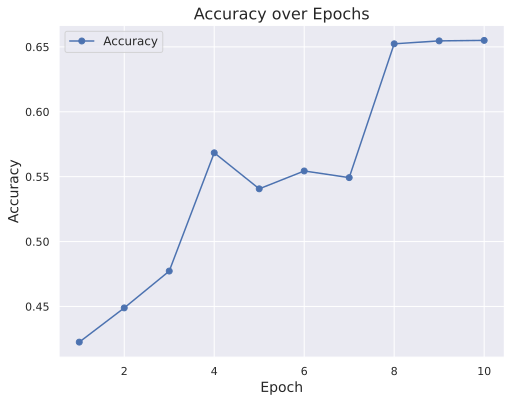

In [36]:
supervised_trainer.plot_accs()

In [37]:
# for params in cnn_network.convnet.parameters():
#   params.requires_grad = True

In [38]:
simclr_supervised_trainer = Classification_trainer(hparams, copy.deepcopy(cnn_network), "SimCLR")

Files already downloaded and verified
Files already downloaded and verified


In [39]:
simclr_supervised_trainer.run()

Training


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.71325


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.633625


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.75475


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.701125


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.75125


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.761625


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.771875


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.81675


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.8175


  0%|          | 0/79 [00:00<?, ?batch/s]

  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.820875
Best Model is at comms : 10
Testing best model


<ipython-input-32-d712843efb0b>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


  0%|          | 0/125 [00:00<?, ?batch/s]

Test accuracy is 0.820875
Best Accuracy is: 0.820875 at Epoch: 9


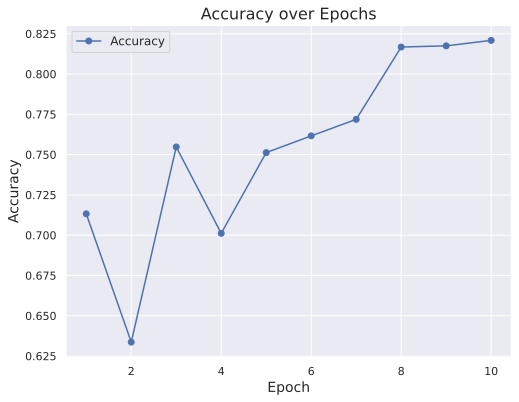

In [40]:
simclr_supervised_trainer.plot_accs()

###Question:

- How does the performance of the ResNet trained from scratch compare to the SimCLR-pretrained model?
- Why do you think the contrastive learning model outperforms the ResNet trained from scratch?
- What does this suggest about the advantages of self-supervised learning when labeled data is scarce?


In [41]:
## Plotting TSNE features
simclr_feats = []
random_feats = []
all_labels = []
simclr_supervised_trainer.model.eval()
simclr_supervised_trainer.model.cuda()

supervised_trainer.model.eval()
supervised_trainer.model.cuda()
for i, (batch_imgs, batch_labels) in tqdm(enumerate(test_data_loader)):
    if i == 60:
        break
    batch_imgs = batch_imgs.to(device)

    simclr_feat, out = simclr_supervised_trainer.model(batch_imgs.to('cuda'))
    random_feat, out = supervised_trainer.model(batch_imgs.to('cuda'))

    simclr_feats.extend(simclr_feat.detach().cpu().numpy())
    random_feats.extend(random_feat.detach().cpu().numpy())
    all_labels.extend(batch_labels.numpy())

0it [00:00, ?it/s]

### t-SNE Plot for Visualizing Feature Representations

This code generates **t-SNE plots** to visualize and compare feature representations of the **test set** learned through two different training approaches: **SimCLR (self-supervised)** and **Supervised training**. t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique that projects high-dimensional features into a 2D space for visualization. Here's what the code does:

1. **Feature Reduction**:
   - It uses t-SNE to reduce the dimensionality of test set features from both SimCLR and Supervised models into two components, making them suitable for visualization.

2. **Visualization**:
   - Two side-by-side scatter plots are created:
     - The **left plot** shows the t-SNE visualization of test set features learned by the SimCLR model.
     - The **right plot** shows the t-SNE visualization of test set features learned by the Supervised model.
   - Each point represents a test image in the feature space, and points are color-coded based on their ground-truth labels.

3. **Comparison**:
   - By comparing the two plots, we can analyze:
     - How well each method clusters similar test samples together.
     - Whether features learned through SimCLR or Supervised training form distinct and meaningful groupings in the test set feature space.

### Importance of t-SNE in This Context:
- **Understanding Feature Quality**: It provides an intuitive way to evaluate how well the models separate test data points of different classes.
- **Cluster Analysis**: Distinct and compact clusters in the test set indicate high-quality and generalizable feature representations.
- **Comparison Tool**: It highlights differences between SimCLR and Supervised learning approaches in terms of their learned test set feature space.

### Questions to Consider:
1. **How do the clusters in the t-SNE plots compare?**
   - Are the clusters tighter and more distinct in one model's test set feature space than the other?

2. **What does this tell you about the quality of features learned by SimCLR compared to Supervised learning on the test set?**

3. **Do you observe any overlap or poorly separated clusters in either plot? What might this indicate about the limitations of the corresponding model?**

4. **Based on the visualization of the test set features, which approach do you think generalizes better to unseen data, and why?**

Reflect on these questions as you analyze the t-SNE visualizations to better understand the differences between self-supervised and supervised learning on the test set.

---

#### Tasks to Complete:

You need to complete the code in following plot function.

1. **Initialize t-SNE**:
   - Create two instances of the `TSNE` class from `sklearn.manifold` for the two feature sets (`features1` and `features2`).
   - Set `n_components=2` to reduce the dimensionality to 2D.
   - Use the provided `random_state` argument to ensure reproducibility.

2. **Reduce Features**:
   - Use the `fit_transform` method of the t-SNE objects to transform the high-dimensional feature sets into 2D representations.
   - Store the transformed features in `reduced_features1` and `reduced_features2`.

#### Hints:
- Use the provided arguments `perplexity` and `random_state` for consistent and meaningful results.
- Check the t-SNE documentation for details.

---


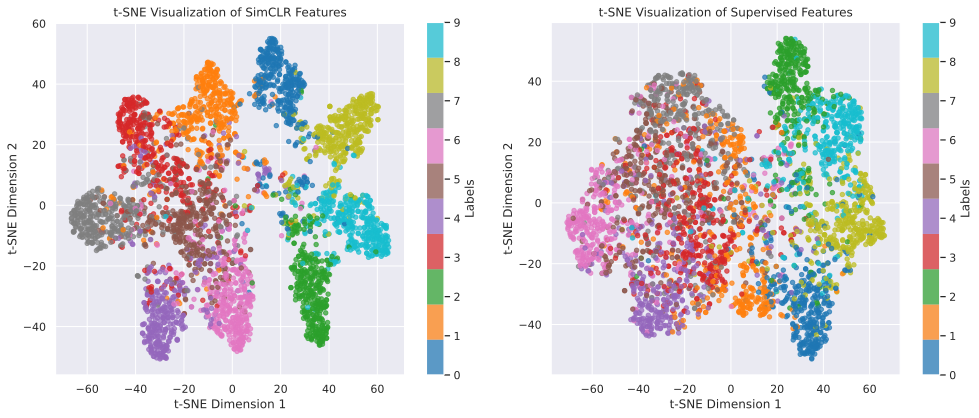

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_dual_tsne(features1, features2, labels1, labels2, labels_name1="SimCLR", labels_name2="Supervised", perplexity=30, random_state=42):
    """
    Generate and plot t-SNE visualizations for two feature sets.

    Args:
        features1 (np.ndarray): First feature set.
        features2 (np.ndarray): Second feature set.
        labels1 (np.ndarray): Labels for the first feature set.
        labels2 (np.ndarray): Labels for the second feature set.
        labels_name1 (str): Label for the first feature set in the plot.
        labels_name2 (str): Label for the second feature set in the plot.
        perplexity (float): Perplexity for t-SNE.
        random_state (int): Random state for reproducibility.
    """
    #### START ######
    ### WRITE CODE HERE ###
    tsne1 = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    tsne2 = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    reduced_features1 = tsne1.fit_transform(features1, labels1)
    reduced_features2 = tsne2.fit_transform(features2, labels2)

    #### END #####

    # Plot t-SNE for SimCLR Features
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(
        reduced_features1[:, 0], reduced_features1[:, 1], c=labels1, cmap='tab10', s=20, alpha=0.7
    )
    plt.colorbar(scatter1, label='Labels')
    plt.title(f't-SNE Visualization of {labels_name1} Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Plot t-SNE for Supervised Features
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(
        reduced_features2[:, 0], reduced_features2[:, 1], c=labels2, cmap='tab10', s=20, alpha=0.7
    )
    plt.colorbar(scatter2, label='Labels')
    plt.title(f't-SNE Visualization of {labels_name2} Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    plt.tight_layout()
    plt.show()

# Convert features and labels to numpy arrays
simclr_feats_np = np.array(simclr_feats)
random_feats_np = np.array(random_feats)
all_labels_np = np.array(all_labels)

# Call the function to plot the t-SNE plots
plot_dual_tsne(simclr_feats_np, random_feats_np, all_labels_np, all_labels_np, labels_name1="SimCLR", labels_name2="Supervised")